# Blueberry Yield Prediction

## Introduction

To predict the blueberry yield based on factors affecting pollination efficiency. In this notebook an ensemble machine learning technique using optuna will used for the prediction of the yield. By optimizing the ensemble model, we aim to provide insights into the factors influencing wild blueberry yield.

In [7]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning Models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from scipy.cluster.hierarchy import linkage, dendrogram

# Import Optuna
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import r2_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import logging
# Set the log level for the optuna package to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load the Data

In [6]:
train_df = pd.read_csv('../artifacts/data/train.csv')
train_df.drop('id', axis = 1, inplace = True)
train_df.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


## Exploratory Data Analysis

1. **`Clonesize [Square Meter]`** : The size of the blueberry clones could impact the overall yield because larger clones may produce more fruit. However, the relationship may not be linear, as other factors can also affect fruit production.

2. **`Honeybee, Bumbles bee, Andrena bee, Osmia bee [Square meter/mins]`** : The densities of various bee species are crucial for pollination efficiency, which directly impacts fruit set and yield. Different bee species may have varying levels of effectiveness in pollinating wild blueberries.

3. **`MaxOfUpperTRange, MinOfUpperTRange, AverageOfUpperTRange, MaxOfLowerTRange, MinOfLowerTRange, AverageOfLowerTRange [Celcius]`** : Temperature ranges can significantly affect plant growth and pollinator activity. Extreme temperatures can cause stress in plants or limit pollinator activity, which could negatively impact the yield.

4. **`RainingDays, AverageRainingDays [Days]`** : Rainy days can impact the yield in various ways. On the one hand, adequate water availability is essential for plant growth. On the other hand, excessive rain or rain during the bloom season can reduce pollinator activity and affect fruit set.

5. **`Fruitset[proportion]`** : Fruit set refers to the proportion of flowers that develop into fruits. This is a critical factor in determining the yield, as a higher fruit set usually results in a higher yield.

6. **`Fruitmass [grams]`** : The mass of individual fruits is also an important factor, as larger fruits contribute more to the overall yield. Variability in fruit mass can be influenced by factors such as pollination efficiency, resource availability, and environmental conditions.

7. **`Seeds [unit]`** : The number of seeds per fruit can have a secondary impact on yield. Although not a direct determinant of yield, a higher number of seeds might indicate better pollination, which could contribute to a higher fruit set and yield.

In [8]:
desc = train_df.describe().T
desc['nunique'] = train_df.nunique()
desc['%unique'] = desc['nunique'] / len(train_df) * 100
desc['null'] = train_df.isna().sum()
desc

,count,mean,std,min,25%,50%,75%,max,nunique,%unique,null
clonesize,15289.0,19.704690,6.595211,10.000000,12.500000,25.000000,25.000000,40.000000,6,0.039244,0
honeybee,15289.0,0.389314,0.361643,0.000000,0.250000,0.500000,0.500000,18.430000,7,0.045785,0
bumbles,15289.0,0.286768,0.059917,0.000000,0.250000,0.250000,0.380000,0.585000,11,0.071947,0
andrena,15289.0,0.492675,0.148115,0.000000,0.380000,0.500000,0.630000,0.750000,16,0.104650,0
osmia,15289.0,0.592355,0.139489,0.000000,0.500000,0.630000,0.750000,0.750000,14,0.091569,0
MaxOfUpperTRange,15289.0,82.169887,9.146703,69.700000,77.400000,86.000000,86.000000,94.600000,6,0.039244,0
MinOfUpperTRange,15289.0,49.673281,5.546405,39.000000,46.800000,52.000000,52.000000,57.200000,5,0.032703,0
AverageOfUpperTRange,15289.0,68.656256,7.641807,58.200000,64.700000,71.900000,71.900000,79.000000,5,0.032703,0
MaxOfLowerTRange,15289.0,59.229538,6.610640,50.200000,55.800000,62.000000,62.000000,68.200000,6,0.039244,0
MinOfLowerTRange,15289.0,28.660553,3.195367,24.300000,27.000000,30.000000,30.000000,33.000000,7,0.045785,0


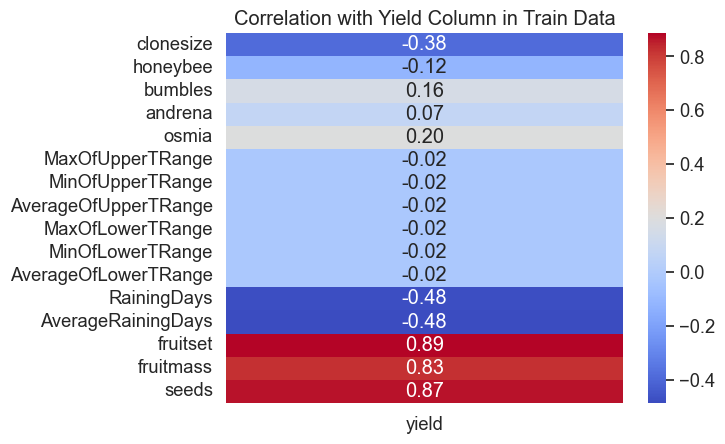

In [9]:
corr = train_df.corr()
target_corr = corr['yield'].drop('yield')

# Create a heatmap of the correlations with the target column
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Yield Column in Train Data')
plt.show()

**Insight**:
1. We can observe that `fruitmass` is **highly correlated** to `yield`
2. `AverageRainingDays` and `clonesize` are **moderately negatively correlated** to `yield`

In [10]:
# Create a correlation matrix
correlation_matrix = train_df.corr()

# Set a correlation threshold (e.g., 0.5 or -0.5)
correlation_threshold = 0.1

# Get the correlations with the target variable (yield)
target_correlations = correlation_matrix['yield']

# Filter the features that have a correlation above the threshold (in absolute value) with the target variable
important_features = target_correlations[abs(target_correlations) >= correlation_threshold].index.tolist()

# Display the important features
print("Important features based on the Correlation threshold with the fruit yield column:", important_features)

# Create a new DataFrame with only the important features
important_data = train_df[important_features]

Important features based on the Correlation threshold with the fruit yield column: ['clonesize', 'honeybee', 'bumbles', 'osmia', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']


### Violin Plots

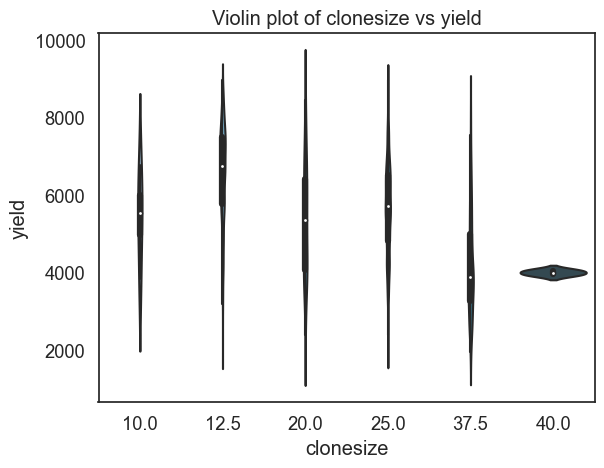

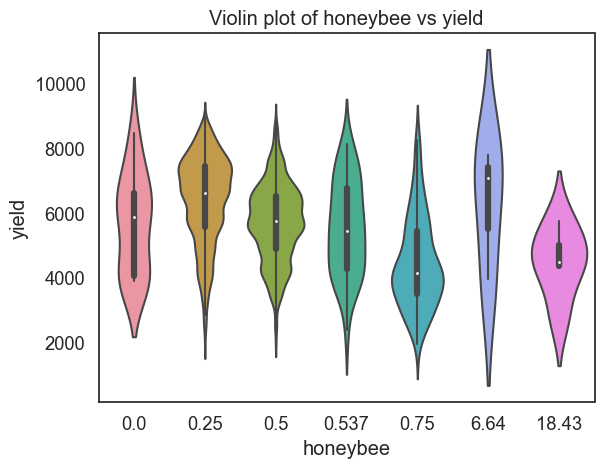

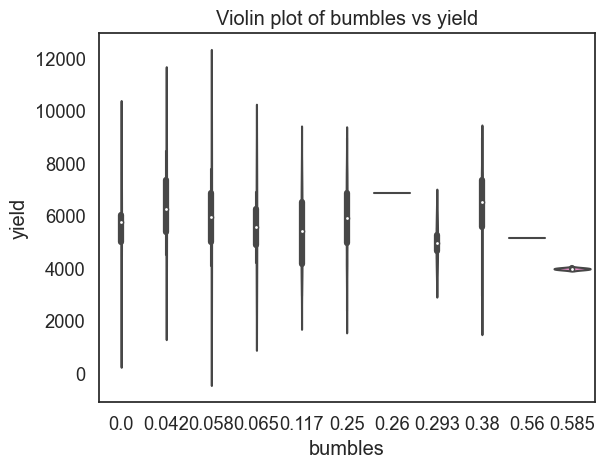

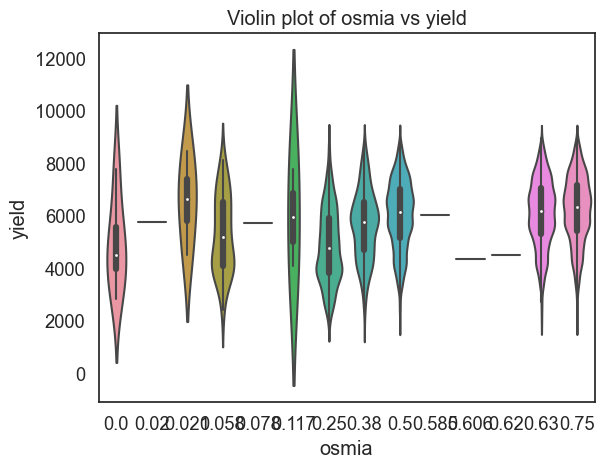

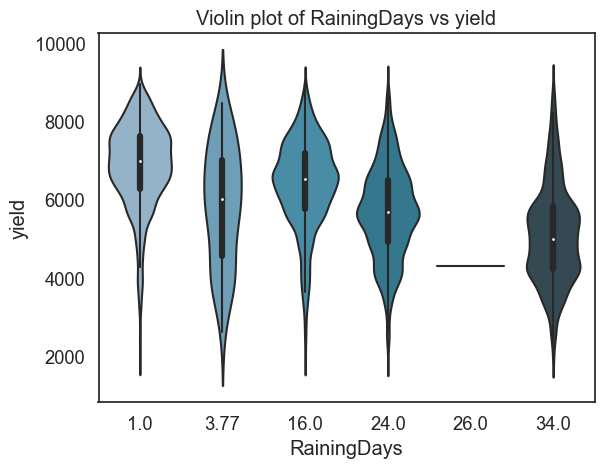

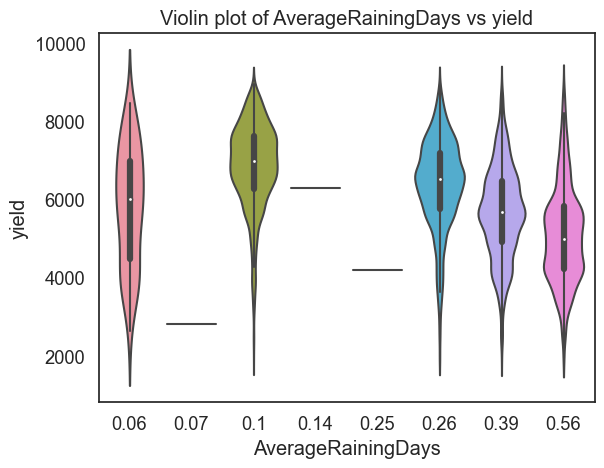

In [11]:
# Create violin plots for each feature against the target variable (yield)
for feature in important_features:
    if feature != 'yield' and feature != 'fruitset' and feature != 'fruitmass' and feature != 'seeds':
        plt.figure()
        sns.violinplot(x=feature, y='yield', data=important_data)
        plt.title(f"Violin plot of {feature} vs yield")
        plt.show()

### Scatter Plots

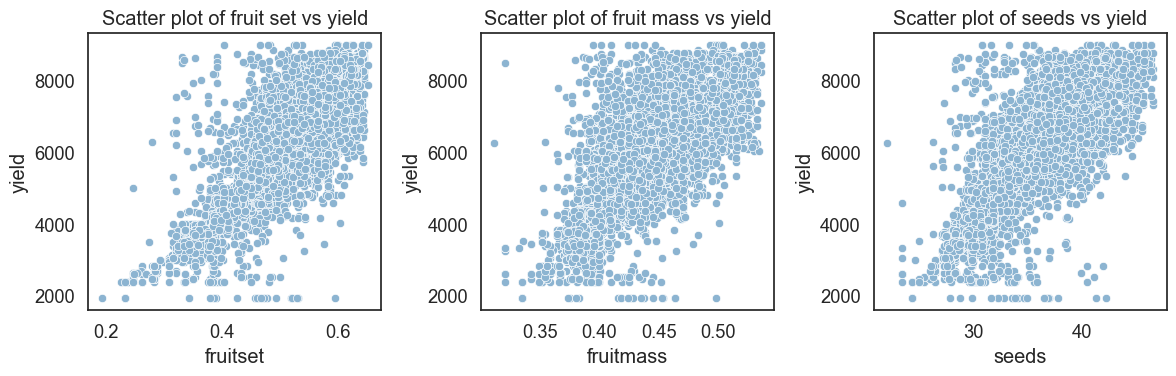

In [12]:
# Create scatter plots for fruit set, fruit mass, and seeds against the target variable (yield)
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
sns.scatterplot(x='fruitset', y='yield', data=important_data)
plt.title("Scatter plot of fruit set vs yield")

plt.subplot(1, 3, 2)
sns.scatterplot(x='fruitmass', y='yield', data=important_data)
plt.title("Scatter plot of fruit mass vs yield")

plt.subplot(1, 3, 3)
sns.scatterplot(x='seeds', y='yield', data=important_data)
plt.title("Scatter plot of seeds vs yield")

plt.tight_layout()
plt.show()

### Feature Engineering

1. `Temperature range`: Instead of using the upper and lower temperature ranges separately, we could create a new feature for the daily temperature range (upper - lower). This could help capture the impact of temperature fluctuations on pollination and yield.

2. `Temperature extremes`: Create binary features indicating whether the daily temperature exceeds certain thresholds (e.g., extreme high or low temperatures). These features could help identify days with potentially harmful temperatures that could affect pollination and yield.

3. `Total bee density`: Sum the densities of all bee species (Honeybee, Bumbles bee, Andrena bee, Osmia bee) to create a new feature for the total bee density. This could help capture the combined effect of all bee species on pollination and yield.

4. `Bee species dominance`: Calculate the proportion of each bee species in the field, which can help capture the relative importance of each bee species in pollination.

5. `Rain intensity`: Instead of just counting rainy days, you could calculate the average daily precipitation during the bloom season. This could provide a more accurate representation of the water availability during the bloom season.

6. `Interaction features` : The impact of total bee density with change in temparture range and rain intensity will allow to understand how the pollination and yield fluctuate.

In [13]:
# 1. Temperature range
train_df['TemperatureRange'] = train_df['MaxOfUpperTRange'] - train_df['MinOfLowerTRange']

# 2. Temperature extremes
threshold_high = 71.9  
threshold_low = 50    

train_df['ExtremeHighTemp'] = (train_df['AverageOfUpperTRange'] > threshold_high).astype(int)
train_df['ExtremeLowTemp'] = (train_df['AverageOfLowerTRange'] < threshold_low).astype(int)

# 3. Total bee density
train_df['TotalBeeDensity'] = train_df['honeybee'] + train_df['bumbles'] + train_df['andrena'] + train_df['osmia']

# 4. Bee species dominance
total_density = train_df['honeybee'] + train_df['bumbles'] + train_df['andrena'] + train_df['osmia']
train_df['HoneybeeDominance'] = train_df['honeybee'] / total_density
train_df['BumblesBeeDominance'] = train_df['bumbles'] / total_density
train_df['AndrenaBeeDominance'] = train_df['andrena'] / total_density
train_df['OsmiaBeeDominance'] = train_df['osmia'] / total_density

# 5. Rain intensity
train_df['RainIntensity'] = train_df['AverageRainingDays'] / train_df['RainingDays']

# 6. Interaction features
train_df['BeeDensity_TemperatureInteraction'] = train_df['TotalBeeDensity'] * train_df['TemperatureRange']
train_df['BeeDensity_RainInteraction'] = train_df['TotalBeeDensity'] * train_df['RainIntensity']

train_df

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,...,ExtremeHighTemp,ExtremeLowTemp,TotalBeeDensity,HoneybeeDominance,BumblesBeeDominance,AndrenaBeeDominance,OsmiaBeeDominance,RainIntensity,BeeDensity_TemperatureInteraction,BeeDensity_RainInteraction
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,...,0,1,2.00,0.250000,0.125000,0.375000,0.250000,0.016250,90.800,0.032500
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,...,0,1,1.75,0.285714,0.142857,0.285714,0.285714,0.016250,79.450,0.028438
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,...,0,0,1.76,0.142045,0.142045,0.357955,0.357955,0.016250,98.560,0.028600
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,...,0,1,1.63,0.153374,0.153374,0.386503,0.306748,0.016250,82.152,0.026488
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,...,0,1,2.01,0.248756,0.124378,0.313433,0.313433,0.016250,101.304,0.032662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,12.5,0.25,0.25,0.38,0.50,77.4,46.8,64.7,55.8,27.0,...,0,1,1.38,0.181159,0.181159,0.275362,0.362319,0.016250,69.552,0.022425
15285,12.5,0.25,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,...,0,0,1.25,0.200000,0.200000,0.200000,0.400000,0.016471,70.000,0.020588
15286,25.0,0.50,0.25,0.38,0.75,77.4,46.8,64.7,55.8,27.0,...,0,1,1.88,0.265957,0.132979,0.202128,0.398936,0.016471,94.752,0.030965
15287,25.0,0.50,0.25,0.63,0.63,69.7,42.1,58.2,50.2,24.3,...,0,1,2.01,0.248756,0.124378,0.313433,0.313433,0.016250,91.254,0.032662


Let's check the correlation of the new features

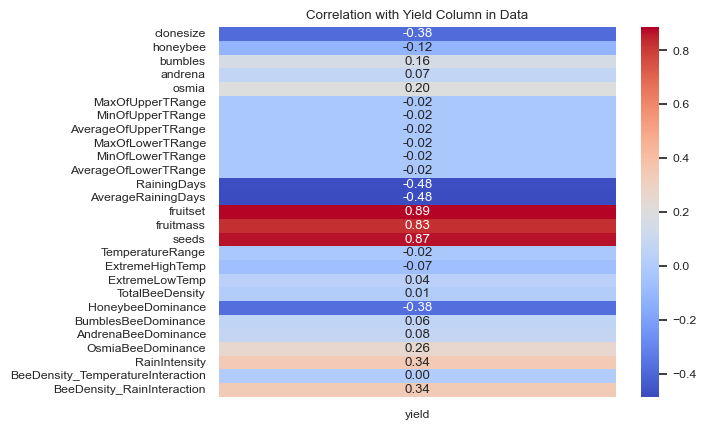

In [14]:
corr = train_df.corr()
# Extract the correlations with the target column
target_corr = corr['yield'].drop('yield')


# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Yield Column in Data')
plt.show()

### Hyperparameter Tuning

In [19]:
# Preprocess the data
X = train_df.drop('yield', axis=1)
y = train_df['yield']

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Define Optuna objectives for each model
# def xgb_objective(trial):
#     n_estimators = trial.suggest_int("n_estimators", 100, 500)
#     learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
#     max_depth = trial.suggest_int("max_depth", 3, 10)
#     subsample = trial.suggest_float("subsample", 0.5, 1)
#     colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

#     model = XGBRegressor(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         random_state=42
#     )

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     r2 = r2_score(y_test, y_pred)
#     return r2

def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 31, 127)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

def catboost_objective(trial):
    iterations = trial.suggest_int("iterations", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 9)
    subsample = trial.suggest_float("subsample", 0.5, 1)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [21]:
# Run Optuna optimization for each model
sampler = TPESampler(seed=42)

# xgb_study = optuna.create_study(direction="maximize", sampler=sampler)
# xgb_study.optimize(xgb_objective, n_trials=50)

lgbm_study = optuna.create_study(direction="maximize", sampler=sampler)
lgbm_study.optimize(lgbm_objective, n_trials=50)

catboost_study = optuna.create_study(direction="maximize", sampler=sampler)
catboost_study.optimize(catboost_objective, n_trials=50)

# Print best hyperparameters for each model from Optuna
# print("Best parameters for XGBoost from Optuna: ", xgb_study.best_params)
print("Best parameters for LightGBM from Optuna: ", lgbm_study.best_params)
print("Best parameters for CatBoost from Optuna: ", catboost_study.best_params)

Best parameters for LightGBM from Optuna:  {'n_estimators': 136, 'learning_rate': 0.03856943497773353, 'max_depth': 5, 'num_leaves': 109, 'subsample': 0.7653310551382453, 'colsample_bytree': 0.9694417669567851}
Best parameters for CatBoost from Optuna:  {'iterations': 425, 'learning_rate': 0.03518043260586421, 'depth': 7, 'l2_leaf_reg': 2, 'subsample': 0.9053149480681327}


### Ensemble Model

In [22]:
# Use the best hyperparameters obtained from the previous GridSearchCV
# xgb_best_params = {'n_estimators': 291, 'learning_rate': 0.02572640965568375, 'max_depth': 4, 'subsample': 0.552187345043806, 'colsample_bytree': 0.8272028535549523}
lgbm_best_params = {'n_estimators': 136, 'learning_rate': 0.03856943497773353, 'max_depth': 5, 'num_leaves': 109, 'subsample': 0.7653310551382453, 'colsample_bytree': 0.9694417669567851}
catboost_best_params = {'iterations': 425, 'learning_rate': 0.03518043260586421, 'depth': 7, 'l2_leaf_reg': 2, 'subsample': 0.9053149480681327}

# Train multiple base models with the best parameters
# xgb = XGBRegressor(**xgb_best_params, random_state=42)
lgbm = LGBMRegressor(**lgbm_best_params, random_state=42)
catboost = CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0)

In [23]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [24]:
# Combine the base models to create an ensemble and assign weights
weights = [0.3, 0.3]
# Combine the base models to create an ensemble
ensemble = VotingRegressor([('lgbm', lgbm), ('catboost', catboost)])
# Train the ensemble model using selected features
ensemble.fit(X_train_selected, y_train)

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(colsample_bytree=0.9694417669567851,
                                           learning_rate=0.03856943497773353,
                                           max_depth=5, n_estimators=136,
                                           num_leaves=109, random_state=42,
                                           subsample=0.7653310551382453)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x000002DD89B44F10>)])

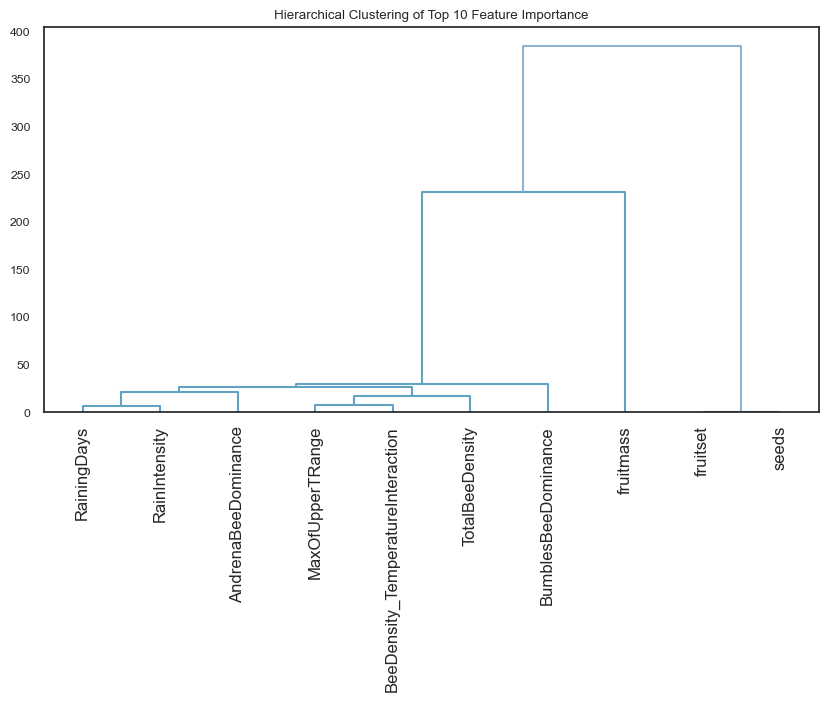

In [26]:
# Train the best performing XGBoost model with the best hyperparameters from Optuna
# best_xgb = XGBRegressor(**xgb_study.best_params, random_state=42)
# best_xgb.fit(X_train, y_train)
best_lgbm = LGBMRegressor(**lgbm_best_params, random_state=42)
best_lgbm.fit(X_train, y_train)

# Get feature importance values
importances = best_lgbm.feature_importances_

# Number of top features to visualize
top_n = 10

# Sort the features by importance and select the top N
sorted_idx = np.argsort(importances)[-top_n:]
top_features = train_df.columns[:-1][sorted_idx].tolist()

# Perform hierarchical clustering on the top N features
linked = linkage(np.array(importances[sorted_idx]).reshape(-1, 1), 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=top_features, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering of Top {} Feature Importance".format(top_n))
plt.xticks(rotation=90) 
plt.show()

In [27]:
# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kfold, scoring='r2')
print("Cross-validation scores: ", cv_scores)
print("Mean CV R-squared: {:.2f}".format(np.mean(cv_scores)))
print("Standard Deviation of CV R-squared: {:.2f}".format(np.std(cv_scores)))

Cross-validation scores:  [0.78994678 0.82385479 0.82125084 0.8357447  0.81590599]
Mean CV R-squared: 0.82
Standard Deviation of CV R-squared: 0.02


In [28]:
# Make predictions using the selected features
y_pred = ensemble.predict(X_test_selected)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared: {:.2f}".format(r2))

Mean Squared Error: 312265.35
R-squared: 0.82


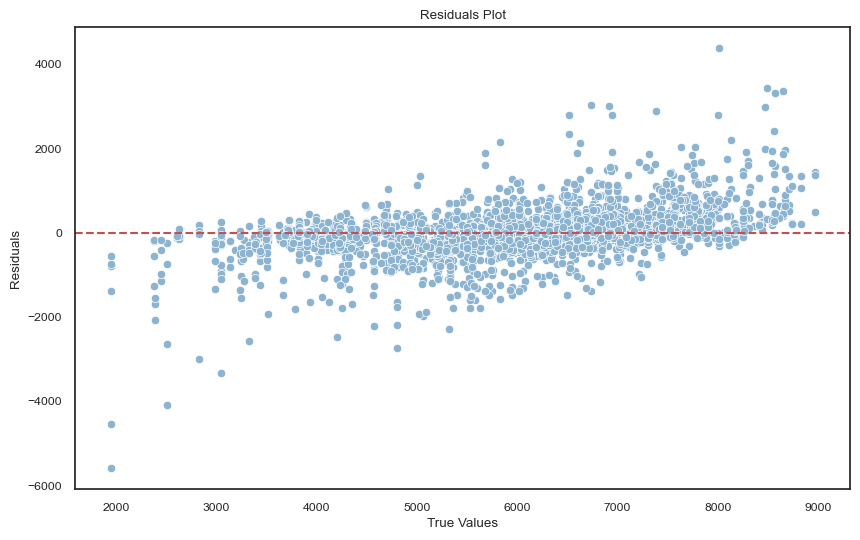

In [29]:
# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [31]:
# Load the test dataset
test_df = pd.read_csv("../artifacts/data/test.csv")

In [32]:
# 1. Temperature range
test_df['TemperatureRange'] = test_df['MaxOfUpperTRange'] - test_df['MinOfLowerTRange']

# 2. Temperature extremes
threshold_high = 72 
threshold_low = 50    

test_df['ExtremeHighTemp'] = (test_df['AverageOfUpperTRange'] > threshold_high).astype(int)
test_df['ExtremeLowTemp'] = (test_df['AverageOfLowerTRange'] < threshold_low).astype(int)

# 3. Total bee density
test_df['TotalBeeDensity'] = test_df['honeybee'] + test_df['bumbles'] + test_df['andrena'] + test_df['osmia']

# 4. Bee species dominance
total_density = test_df['honeybee'] + test_df['bumbles'] + test_df['andrena'] + test_df['osmia']
test_df['HoneybeeDominance'] = test_df['honeybee'] / total_density
test_df['BumblesBeeDominance'] = test_df['bumbles'] / total_density
test_df['AndrenaBeeDominance'] = test_df['andrena'] / total_density
test_df['OsmiaBeeDominance'] = test_df['osmia'] / total_density

# 5. Rain intensity
test_df['RainIntensity'] = test_df['AverageRainingDays'] / test_df['RainingDays']

# 6. Interaction features
test_df['BeeDensity_TemperatureInteraction'] = test_df['TotalBeeDensity'] * test_df['TemperatureRange']
test_df['BeeDensity_RainInteraction'] = test_df['TotalBeeDensity'] * test_df['RainIntensity']

In [33]:
# Get a list of all columns except 'id'
selected_features = test_df.drop('id', axis=1).columns.tolist()

# Select all columns except 'id' from test_df
X_test = test_df[selected_features]

In [34]:
# Scale
X_test_scaled = scaler.transform(X_test)

# Apply feature selection
X_test_selected = selector.transform(X_test_scaled)

# Make predictions
y_test_pred = ensemble.predict(X_test_selected)

In [35]:
# Create a new DataFrame with ID column and predicted yields
result_df = pd.DataFrame({'id': test_df['id'], 'yield': y_test_pred})

# Save the DataFrame
result_df
# result_df.to_csv('predictions.csv', index=False)

,id,yield
0,15289,4308.615614
1,15290,6202.232539
2,15291,7256.559723
3,15292,4752.986285
4,15293,3612.034842
...,...,...
10189,25478,5471.498725
10190,25479,5744.604329
10191,25480,6502.072569
10192,25481,4408.057976


In [36]:
import pickle
pickle.dump(scaler, open('../artifacts/scaling.pkl', 'wb'))
pickle.dump(ensemble, open('../artifacts/ensemble.pkl', 'wb'))